<h1 style='color:purple' align='center'>Project: Potato Disease Classification</h1>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
image_size=256
batch_size=32
channels=3
epochs=10

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 0 1 2 1 2 0 0 0 1 1 0 2 0 0 0 1 1 1 2 0 1 0 2 1 0 0 0 0]


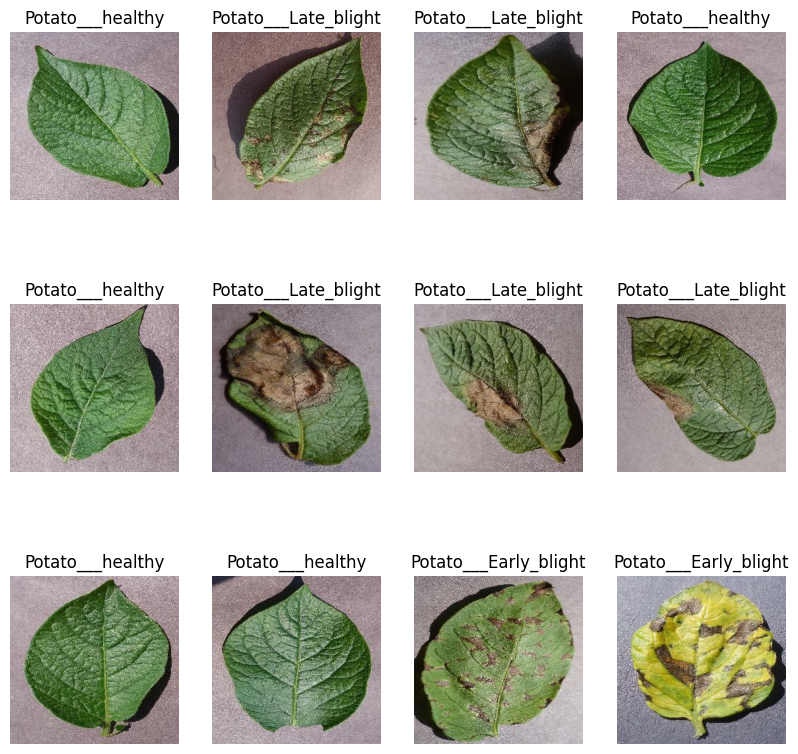

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
input_shape=(batch_size,image_size,image_size,channels)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [25]:
history=model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10


54/54 [==============================] - 32s 557ms/step - loss: 0.9009 - accuracy: 0.4826 - val_loss: 0.8983 - val_accuracy: 0.5885
Epoch 2/10
54/54 [==============================] - 30s 550ms/step - loss: 0.7629 - accuracy: 0.6447 - val_loss: 0.7291 - val_accuracy: 0.6615
Epoch 3/10
54/54 [==============================] - 29s 540ms/step - loss: 0.5754 - accuracy: 0.7425 - val_loss: 0.5445 - val_accuracy: 0.7760
Epoch 4/10
54/54 [==============================] - 29s 546ms/step - loss: 0.3468 - accuracy: 0.8553 - val_loss: 0.2557 - val_accuracy: 0.9010
Epoch 5/10
54/54 [==============================] - 29s 540ms/step - loss: 0.2689 - accuracy: 0.8843 - val_loss: 0.2544 - val_accuracy: 0.8958
Epoch 6/10
54/54 [==============================] - 29s 541ms/step - loss: 0.2656 - accuracy: 0.8906 - val_loss: 0.2482 - val_accuracy: 0.8958
Epoch 7/10
54/54 [==============================] - 29s 545ms/step - loss: 0.1641 - accuracy: 0.9346 - val_loss: 0.1881 - val_accuracy: 0.91

In [26]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 166ms/step - loss: 0.0843 - accuracy: 0.9688


In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [29]:
history.history.keys

<function dict.keys>

In [30]:
history.history["accuracy"]

[0.4826388955116272,
 0.6446759104728699,
 0.7424768805503845,
 0.8553240895271301,
 0.8842592835426331,
 0.890625,
 0.9346064925193787,
 0.9479166865348816,
 0.9288194179534912,
 0.9461805820465088]

In [31]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

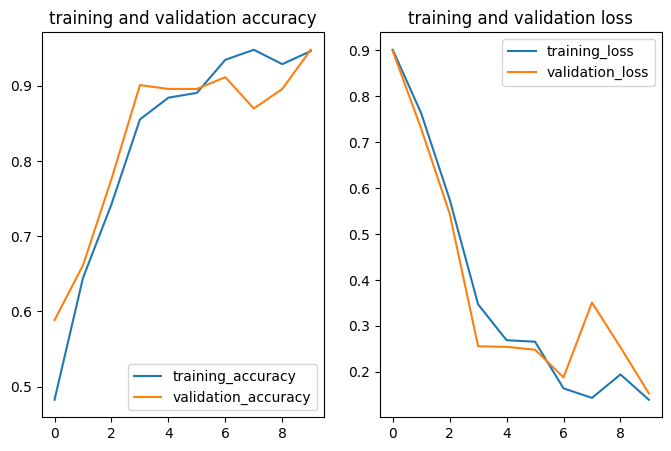

In [37]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label="training_accuracy")
plt.plot(range(epochs),val_acc,label="validation_accuracy")
plt.legend()
plt.title("training and validation accuracy")


plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label="training_loss")
plt.plot(range(epochs),val_loss,label="validation_loss")
plt.legend()
plt.title("training and validation loss")
plt.show()

first image to pridect
actual label : Potato___Late_blight
1/1 [==============================] - 0s 293ms/step
predicted label : Potato___Late_blight


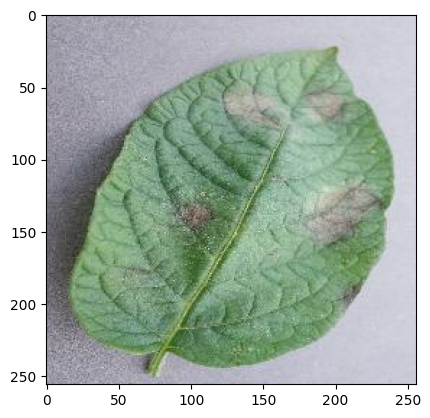

In [33]:
for image_batch, label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype("uint8")
    first_label=label_batch[0].numpy()

    print("first image to pridect")
    plt.imshow(first_image)
    print("actual label :",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    
    print("predicted label :",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)#creat a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*np.max(predictions[0]),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


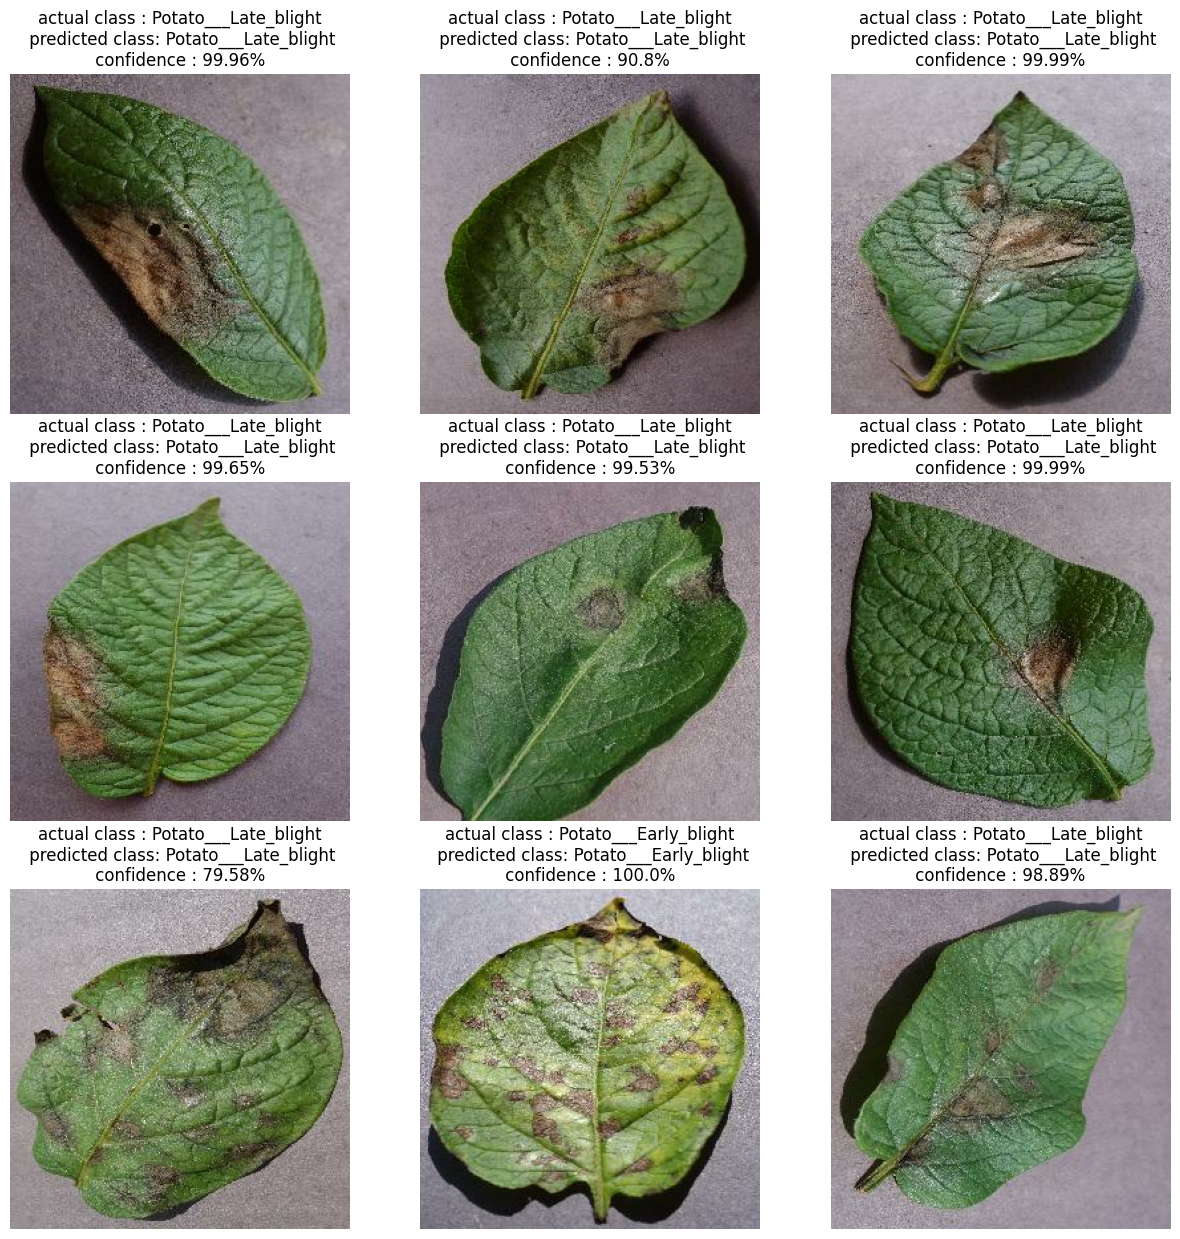

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"actual class : {actual_class}\n predicted class: {predicted_class}\n confidence : {confidence}% ")
        plt.axis("off")

In [36]:
model_version=1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets
